# Figure 2 from Villas Boas et al., 2021 - Geophysical Research Letters
## Environmental conditions during the SWOT pre-launch MASS campaign for the April 9, 2019 flights

#### Data used:
- MASS sea surface height anomaly
- MASS wave directional spectra
- CDIP wave spectra
- ERA5 winds at 10m
- AVISO sea surface height anomaly

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../src')

import glob
import numpy as np
import xarray as xr
from tools import *

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib 
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib import ticker, cm
matplotlib.rcParams.update({'font.size': 16})

#### Reading MASS sea surface height files from up/down and cross wind tracks

In [2]:
# Loading binned point cloud for up/down wind tracks
path_binned_up = '../data/MASS/20190409/binned_point_cloud/upwind/*.nc'
dsu = xr.open_mfdataset(path_binned_up, concat_dim='time')
# Loading binned point cloud for crosswind tracks

path_binned_cross = '../data/MASS/20190409/binned_point_cloud/crosswind/*.nc'
dsc = xr.open_mfdataset(path_binned_cross, concat_dim='time')

# Minimum and maximum time of up/down and cross wind tracks
tmin = min(dsu.time.min(), dsc.time.min())
tmax =  max(dsu.time.max(), dsc.time.max())

For ploting purposes, we average the SSH every 2.5 km to obtain a smoother curve and compare it with AVISO

In [3]:
# Averaging to 2.5 km for physical space plots
up25 = dsu.coarsen(atrack_bin=2500, boundary='trim').mean().compute()
cross25 = dsc.coarsen(atrack_bin=2500, boundary='trim').mean().compute()

# We only need the mean lat and lon for plotting
latu = up25.latitude.mean(dim=['time'])
lonu = up25.longitude.mean(dim=['time'])
latc = cross25.latitude.mean(dim=['time'])
lonc = cross25.longitude.mean(dim=['time'])

#### Reading MASS directional wave spectrum

In [4]:
fnames = sorted(glob.glob('../data/MASS/20190409/dirspec/*.nc'))
ds = xr.open_mfdataset(fnames)

# Directional spectrum
Ekth = ds.Ekth.mean(dim='time').compute()
# Omnidirectional spectrum
Ek = ds.Ek.mean(dim='time').compute()
# scale from rad/m to cycles/km
cpk = 1e3/2/np.pi 
# Converting spectral density to m^2/cycle/km
Ekth_degkm = Ekth*np.pi/180/cpk
# Angular bin width
dth = np.diff(Ekth.theta)[0]
# Wavenumber bin width
dk = np.diff(Ekth.K)[0]

Computes some bulk quantities from the directional spectrum and prints

In [5]:
# Gravity
g = 9.8
# Significant wave heigth
Hs = 4*(Ekth.sum()*dk*dth).values**.5
# Peak wavelength
Lp = 2*np.pi/Ek.K[Ek==Ek.max()][0].values
# Peak period
Tp = (2*np.pi*Lp/g)**.5
# Peak direction
Dp = np.degrees(Ekth.theta[np.where(Ekth==Ekth.max())[0][0]].values)

print('Significant wave height:', Hs)
print('Peak wavelenght:', Lp)
print('Peak period:', Tp)
print('Peak dorection:', Dp)

Significant wave height: 3.0963287369209644
Peak wavelenght: 199.8
Peak period: 11.318128966552665
Peak dorection: 322.1052631578948


#### reading CDIP data from nearby buoys

Loading the CDIP data and computing the mean spectrum averaged over the MASS flight times. 
Here we convert the frequency spectrum from CDIP to wavenumber spectrum using the deep water dispersion relationship:

$$
k = (2\pi f)^2/g
$$

$$
E(k) = E(f)\frac{dk}{df}
$$

In [6]:
# Loads CDIP data from nearby buoys
cdip29 = xr.open_dataset('../data/CDIP/CDIP029_20190409.nc')
cdip94 = xr.open_dataset('../data/CDIP/CDIP094_20190409.nc')
cdip185 = xr.open_dataset('../data/CDIP/CDIP185_20190409.nc')

# Reading CDIP spectrum
Ef29 = cdip29.waveEnergyDensity.mean(dim='waveTime')
Ef94 = cdip94.waveEnergyDensity.mean(dim='waveTime')
Ef185 = cdip185.waveEnergyDensity.mean(dim='waveTime')

freq = Ef29.waveFrequency
# Jacobian to go from f to k
jaco = g/(2*np.pi)**2/2/freq
# wavenumber in radians per m
k = (2*np.pi*freq)**2/g

#### Reading AVISO data

In [7]:
dssh = xr.open_dataset("../data/AVISO/aviso_20190409.nc")
# Interpolating the AVISO gridded data to the MASS tracks lat, lon
slau = dssh.sla.interp(longitude=lonu, latitude=latu)
slac = dssh.sla.interp(longitude=lonc, latitude=latc)

#### Reading ERA5 winds

In [8]:
dw = xr.open_dataset('../data/ERA5/ERA5_20190409.nc')
dw = dw.mean(dim='time')
wnd = (dw.u10**2 + dw.v10**2)**.5

#### Plotting figure 1

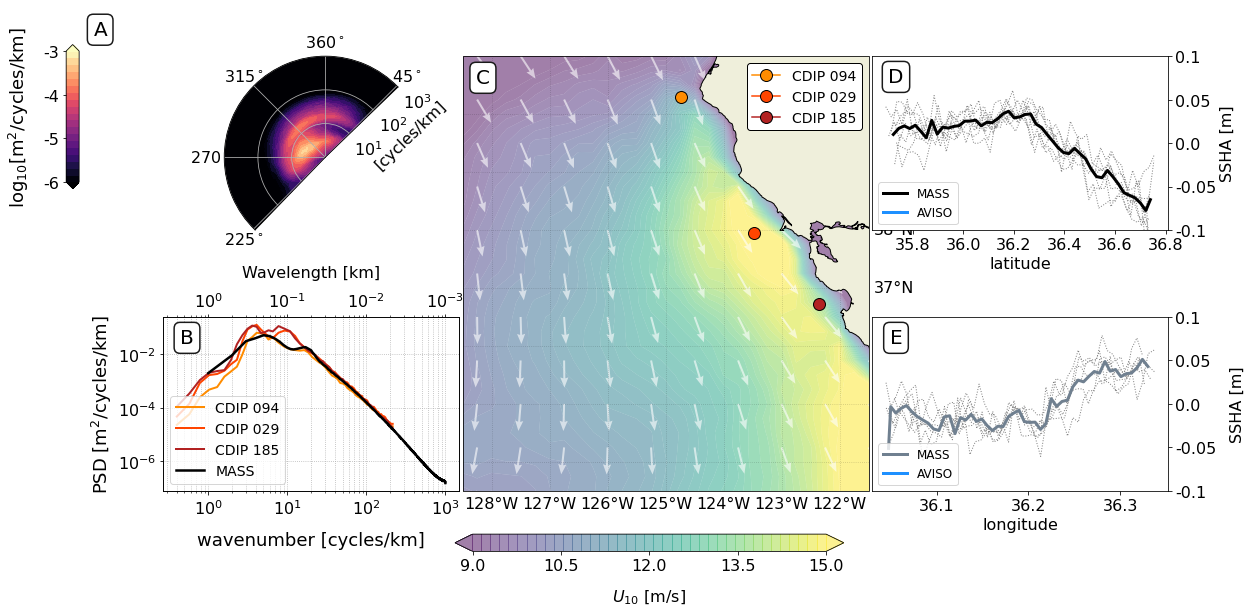

In [9]:
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(18, 8))
gs = fig.add_gridspec(2, 4)
ax1 = fig.add_subplot(gs[0, 0], projection='polar')
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:, 1:3], projection=proj)
ax4 = fig.add_subplot(gs[0, 3])
ax5 = fig.add_subplot(gs[1, 3])

lin = np.linspace(-6, -3., 20)
cs = ax1.contourf(Ekth.theta, np.log10(Ekth.K[1:]*cpk), np.log10(Ekth_degkm[:,1:].T), lin, cmap=cm.magma, extend='both')
thetaticks = np.arange(0,360,45)
thetalabels = ['90$^\circ$', '45$^\circ$', '360$^\circ$', '315$^\circ$',
               '270$^\circ$', '225$^\circ$', '180$^\circ$', '135$^\circ$']
kticks = np.array([1, 2, 3])
klabels = ['10$^1$',  '10$^2$', '10$^3$']
ax1.set_rgrids(kticks, klabels)
ax1.set_thetagrids(thetaticks, thetalabels)
ax1.annotate('[cycles/km]', xy=(0.85, 0.35), xycoords='axes fraction', rotation=44)
ax1.set_thetamin(44)
ax1.set_thetamax(226)
cax = plt.axes([0.05, 0.65, 0.01, 0.25])
cbar = plt.colorbar(cs, cax=cax, orientation='vertical', format="%d")
tick_locator = ticker.MaxNLocator(nbins=3)
cbar.locator = tick_locator
cbar.update_ticks()
cax.yaxis.tick_left()
cbar.ax.yaxis.set_label_position('left')
cbar.set_label('log$_{10}$[m$^2$/cycles/km]', fontsize=18, labelpad=12)

ax2.loglog(k*cpk, Ef94*jaco/cpk, label='CDIP 094', color='darkorange', lw=2)
ax2.loglog(k*cpk, Ef29*jaco/cpk, label='CDIP 029', color='orangered', lw=2)
ax2.loglog(k*cpk, Ef185*jaco/cpk, label='CDIP 185', color='firebrick', lw=2)
ax2.loglog(Ek.K[1:]*cpk, Ek[1:]/cpk, 'k', lw=2.5, label='MASS')
ax2.grid(which='both', ls='dotted')
ax2.legend(loc=3, framealpha=0.8, fontsize=14)
ax2.set_ylabel('PSD [m$^2$/cycles/km]', fontsize=18)
ax2.set_xlabel('wavenumber [cycles/km]', fontsize=18, labelpad=14)
add_second_axis_env(ax2)
for i in range(up25.time.size):
    latu = up25.latitude.isel(time=i)
    sshau = up25.ssha.isel(time=i)
    ax4.plot(latu, sshau, color='0.5', lw=1, ls=':')
for i in range(cross25.time.size):
    lonc = cross25.longitude.isel(time=i)
    sshac = cross25.ssha.isel(time=i)
    ax5.plot(lonc, sshac, color='0.5', lw=1, ls=':')

ax4.plot(up25.latitude.mean(dim=['time'])[:-2], 
         up25.ssha.mean(dim='time')[:-2], 'k', lw=3, label='MASS')
ax4.plot(slau.latitude, slau-slau.mean(), color='dodgerblue', lw=3, label='AVISO')
ax5.plot(cross25.longitude.mean(dim=['time']),
         cross25.ssha.mean(dim='time'), 'slategrey', label='MASS', lw=3)
ax5.plot(slac.longitude, slac-slac.mean(), color='dodgerblue', lw=3, label='AVISO')
ax4.set_xlabel('latitude')
ax4.set_ylabel('SSHA [m]')
ax4.set_ylim([-0.1, 0.1])
ax4.legend(loc=3, fontsize=12)
ax5.set_ylabel('SSHA [m]', labelpad=14)
ax5.set_xlabel('longitude')
ax5.set_ylim([-0.1, 0.1])
ax5.legend(loc=3, fontsize=12)
ax4.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax5.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax4.yaxis.tick_right()
ax5.yaxis.tick_right()
ax4.set_yticks([-0.1, -0.05, 0, 0.05, 0.1])
ax4.set_yticklabels([-0.10, -0.05, 0.00, 0.05, 0.10], ha = 'left')
ax4.yaxis.set_label_position("right")
ax5.yaxis.set_label_position("right")
ax5.set_yticks([-0.1, -0.05, 0, 0.05, 0.1])
ax5.set_yticklabels([-0.10, -0.05, 0.00, 0.05, 0.10], ha = 'left')

nd=3
lin = np.linspace(9, 15, 40)
extent = [-128.5, -121.5, 33.5, 41]
ax3.plot(lonu, latu, transform=proj, color='k', lw=3)
ax3.plot(lonc, latc, transform=proj, color='slategrey', lw=3)
ax3.quiver(wnd.longitude[::nd]-360, wnd.latitude[::nd],
           dw.u10[::nd,::nd]/wnd[::nd,::nd], dw.v10[::nd,::nd]/wnd[::nd,::nd],
           scale=15, width=0.005, headwidth=4, color='w', alpha=0.6,
           zorder=2, transform=proj)
cs = ax3.contourf(wnd.longitude-360, wnd.latitude, wnd, lin,
                  cmap='viridis', extend='both', alpha=0.5, antialiased=True)
ax3.plot(cdip94.metaStationLongitude.values, cdip94.metaStationLatitude.values,
         transform=proj, marker='o', ms=12, color='darkorange', mec='k', label='CDIP 094')
ax3.plot(cdip29.metaStationLongitude.values, cdip29.metaStationLatitude.values,
         transform=proj, marker='o', ms=12, color='orangered', mec='k', label='CDIP 029')
ax3.plot(cdip185.metaStationLongitude.values, cdip185.metaStationLatitude.values,
         transform=proj, marker='o', ms=12, color='firebrick', mec='k', label='CDIP 185')
ax3.legend(loc=1, fontsize=14, edgecolor='k', framealpha=1)
cax = plt.axes([0.35, 0.02, 0.3, 0.03])
cbar = plt.colorbar(cs, cax=cax, orientation='horizontal', format="%.1f")
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.set_label('$U_{10}$ [m/s]', labelpad=14)
ax3.set_extent(extent)
ax3.add_feature(cfeature.LAND, edgecolor='black', zorder=2)
g = ax3.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='dotted')
g.left_labels = False
g.top_labels = False
plt.subplots_adjust(wspace=-0.2, hspace=0.5)
plt.tight_layout()
bbox_props = dict(boxstyle="round", fc="w", lw=1.5, ec="0.1", alpha=1)
ax1.annotate("A", xy=(0.08, 0.95), xycoords='figure fraction', ha="center", va="center", size=20,
        bbox=bbox_props)
ax2.annotate("B", xy=(0.08, 0.88), xycoords='axes fraction', ha="center", va="center", size=20,
        bbox=bbox_props)
ax3.annotate("C", xy=(0.05, 0.95), xycoords='axes fraction', ha="center", va="center", size=20,
        bbox=bbox_props)
ax4.annotate("D", xy=(0.08, 0.88), xycoords='axes fraction', ha="center", va="center", size=20,
        bbox=bbox_props)
ax5.annotate("E", xy=(0.08, 0.88), xycoords='axes fraction', ha="center", va="center", size=20,
        bbox=bbox_props)
plt.savefig('../figs/figure01.png', dpi=150, bbox_inches='tight', facecolor="w" )